In [3]:
from linkage.linkage import *
import numpy as np
import matplotlib.pyplot as plt

## Download dataset to a variable and display it

We use an example dataset available at the accelerated HDBSCAN Git repository [https://github.com/scikit-learn-contrib/hdbscan].

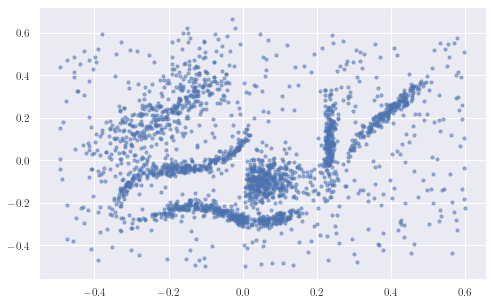

In [4]:
from urllib.request import urlopen
from io import BytesIO

url = "https://github.com/scikit-learn-contrib/hdbscan/blob/4052692af994610adc9f72486a47c905dd527c94/notebooks/clusterable_data.npy?raw=true"

f = urlopen(url)
rf = f.read()
X = np.load(BytesIO(rf))

fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(8)
sns.set(rc={'text.usetex': True}) ; _ = plt.scatter(X.T[0], X.T[1], s=10, alpha = 0.5)

## Run gamma-linkage

### 1. Fit metric probability space

If one wants to use a different kernel, or knows one will not use curves
with a k-intercept that is too large, one can, for instance, fit as follows
[x.fit(kernel="epanechnikov", maxk=300)]

### 2. Compute the hierarchical clustering using the curve gamma

See below for how we have chosen the parameters for the curve gamma.

### 3. Compute the persistence-base flattening and display it

See below for how we have chosen the parameter for the persistence-based flattening.


In [5]:
# 1.
x = MPSpace(X)
x.fit()

# 2.
K_INTERCEPT = 0.03
S_INTERCEPT = 0.1
gamma = Gamma_curve.linear_interpolator_alpha_s_indexed(K_INTERCEPT, S_INTERCEPT)
hc = x.gamma_linkage(gamma)

# 3.
N_CLUSTERS = 6
c = hc.persistence_based_flattening(num_clusters=N_CLUSTERS)

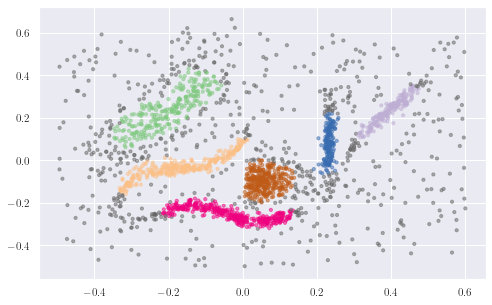

In [6]:
fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(8)
sns.set(rc={'text.usetex': True}) ; _ = plt.scatter(X.T[0], X.T[1], s=10, alpha = 0.5, c = -c[1], cmap="Accent")

## Parameter selection

### 1. Run gamma-linkage with a range of curves

We compute max_s to be the smallest radius for which the Rips graph of the dataset becomes connected.
We choose a range of k from 0.01 to 0.1 (1/100 to 1/10 of the dataset).
We run gamma-linkage 500 times with parameters k and max_s.
We display the total persistences as the parameters change.

#### Note: the most persistent point (which has infinite total persistence) is not displayed.
#### Note: this cell runs gamma-linkage 500 times, so it can take several seconds to run. Improved runtime will be addressed in the next version. 

The plot suggests that, across paramaters k, there are 6 high persistent classes: the curve that is separated from the rest, and the infinite persistence one that is not displayed.

We choose K_INTERCEPT = 0.03 and S_INTERCEPT = 0.1.

### 2. Display the persistence diagram of gamma-linkage with the chose curve
 
This confirms that there are 6 high persistence points.
We choose N_CLUSTERS = 6 for the persistence based flattening.

In [7]:
# 1.
max_s = x.connection_radius()
initial_k = 0.005
final_k = 0.1
N_PARAMETERS = 500

TOL = 1e-15 ; INF = 1e15

def total_persistences(bd : np.array) -> np.array :
    pers = np.abs(bd[:,0] - bd[:,1])
    pers = pers[pers > TOL]
    pers = pers[pers < INF]
    return pers

gammas = [ Gamma_curve.linear_interpolator_alpha_s_indexed(k, max_s) for k in np.linspace(initial_k, final_k, num=N_PARAMETERS) ]

# using end="infinty" when constructing the persistence diagram makes the most persistent point die at infinity, and thus be ignored when constructing the total persistence curves, below
persistences = [ total_persistences(x.gamma_linkage(curve).PD(end="infinity")[0]) for curve in gammas ]

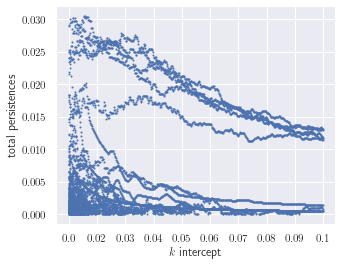

In [8]:
points = []
for i in range(N_PARAMETERS) :
    for y in persistences[i] :
        points.append([i,y])
points = np.array(points)

sns.set(rc={'text.usetex': True}) ; fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(10) ; plt.xlabel("$k$ intercept") ; plt.ylabel("total persistences") ; fig1.set_figheight(4) ; fig1.set_figwidth(5)


def to_tex(ns) :
    return ["$" + str(n) + "$" for n in ns]

_ = plt.xticks(np.linspace(0, N_PARAMETERS, num=10), to_tex(np.rint(100*np.linspace(initial_k, final_k, num=10))/100) )
_ = plt.scatter(points.T[0], points.T[1], s = 1, alpha = 1)

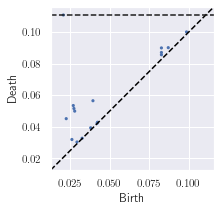

In [9]:
# 2.

from persim import plot_diagrams

pd = hc.PD(end="infinity")

fig1, ax1 = plt.subplots() ; fig1.set_figheight(3) ; fig1.set_figwidth(3)
sns.set(rc={'text.usetex': True}) ; plot_diagrams(pd[0], show=True, legend=False, size = 10)

## What if we use a horizontal curve (like HDBSCAN)?

We now use the same range for k, but we use horizontal curves, so we do not expect the diagram of total persistences to consist of continuous curves.

In [10]:
# 1.
gammas_h = [ Gamma_curve.constant_k_alpha_s_indexed(k) for k in np.linspace(initial_k, final_k, num=N_PARAMETERS) ]

persistences_h = [ total_persistences(x.gamma_linkage(curve).PD(end="infinity")[0]) for curve in gammas_h ]

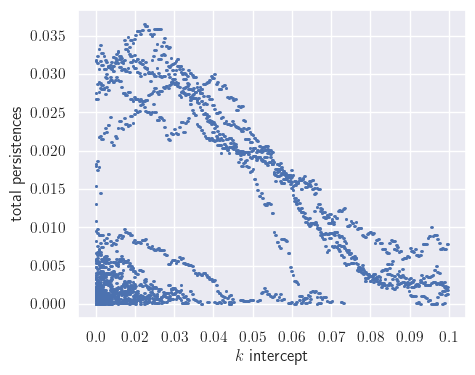

In [11]:
points_h = []
for i in range(N_PARAMETERS) :
    for y in persistences_h[i] :
        points_h.append([i,y])
points_h = np.array(points_h)

sns.set(rc={'text.usetex': True}) ; fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(10) ; plt.xlabel("$k$ intercept") ; plt.ylabel("total persistences") ; fig1.set_figheight(4) ; fig1.set_figwidth(5)


_ = plt.xticks(np.linspace(0, N_PARAMETERS, num=10), to_tex(np.rint(100*np.linspace(initial_k, final_k, num=10))/100) )
_ = plt.scatter(points_h.T[0], points_h.T[1], s = 1, alpha = 1)

### (Optional) visualize the kernel density bifiltration


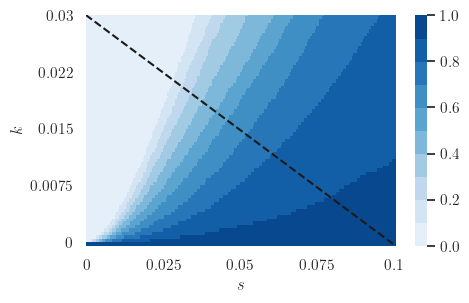

In [12]:
M = x.its_shadow(K_INTERCEPT, S_INTERCEPT, n_bins = 200)
ax = plot_shadow(M, n_ticks = 5, gammas = [gamma], n_shadows = 10, h_size=5,v_size=3)

plt.yticks(rotation=0) ; plt.xticks(rotation=0) ; _ = ax.set_xlabel("$s$") ; _ = ax.set_ylabel("$k$")